**CS7641 Assignment 1 - Supervised Learning - Robert Kiesler (rkiesler3)**

Little,Max. (2008). Parkinsons. UCI Machine Learning Repository. https://doi.org/10.24432/C59C74.

https://archive.ics.uci.edu/dataset/174/parkinsons

#Initial Library Imports and Labeling

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import seaborn as sns
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import time

In [ ]:
df = pd.read_csv("parkinsons.data")

#df = df.drop(columns=["SampleCodeNumber"])

df.head(n=10)

In [ ]:
df.isnull().sum()

In [ ]:
df.dtypes

In [ ]:
df.shape

In [ ]:
#This column will print unique values of each column, point is to check for any weird values like "?"
for i in df.columns:
    print("*************************************************",i,"************************************************************")
    print()
    print(set(df[i].tolist()))
    print()

In [ ]:
#Checking for label imbalance, more people with Parkinson's (1) than not (0) - to avoid models skewing accuracy, will fix in subsequent code
temp = df['status'].value_counts()
temp_df = pd.DataFrame({'status': temp.index, 'values': temp.values})
print(sns.barplot(x='status', y='values', data=temp_df))

#Train, Validation and Test datasets. Re-balancing included.


In [ ]:
  #Before fixing imbalance with oversampler
  X=df.drop(['status', 'name'], axis=1)
  y=df["status"]
  print(Counter(y))

In [16]:
# preprocessor
def preprocess_data(X, y):
    ros = RandomOverSampler()
    X_ros, y_ros = ros.fit_resample(X, y)
    print(Counter(y_ros))

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_ros)

    pca = PCA(.95)
    X_PCA = pca.fit_transform(X_scaled)
    return X_PCA, y_ros

# splitting data
def split_data(X, y, test_size=0.2, random_state=7):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)
    return X_train, X_valid, X_test, y_train, y_valid, y_test


X_PCA, y_ros = preprocess_data(X, y)
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(X_PCA, y_ros)

Counter({1: 147, 0: 147})


In [ ]:
# After fixing imbalance with oversampler
# ros = RandomOverSampler()
# X_ros, y_ros = ros.fit_resample(X, y)
# print(Counter(y_ros))


In [10]:
# scaler = StandardScaler() #Creating scaler from sklearn because some of X values don't scale well (e.g. 300 vs 0.3) - this is to prevent overfitting
# X = scaler.fit_transform(X_ros)
# y = y_ros

In [ ]:
# Use PCA as a sort of feature engineering to better fit data into model - this will retain 95% of the variance - in this case, we will need 8 columns to retain 95% of the variance. This end result is that improves the dimensionality of the data to save compute time and complexity
# pca = PCA(.95)
# X_PCA = pca.fit_transform(X)
# print(X.shape)
# print(X_PCA.shape)


In [12]:
#X_train, X_test, y_train, y_test=train_test_split(X_PCA, y, test_size=0.2, random_state=7) #First split at 80% for training data, tand 80%-100% will be for test data

In [ ]:
len(y_train)

235

In [ ]:
sum(y_train == 1) #confirmation of re-balancing

112

In [ ]:
sum(y_train == 0) #confirmation of re-balancing

123

#Decision Tree w/ Pruning Implementation


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

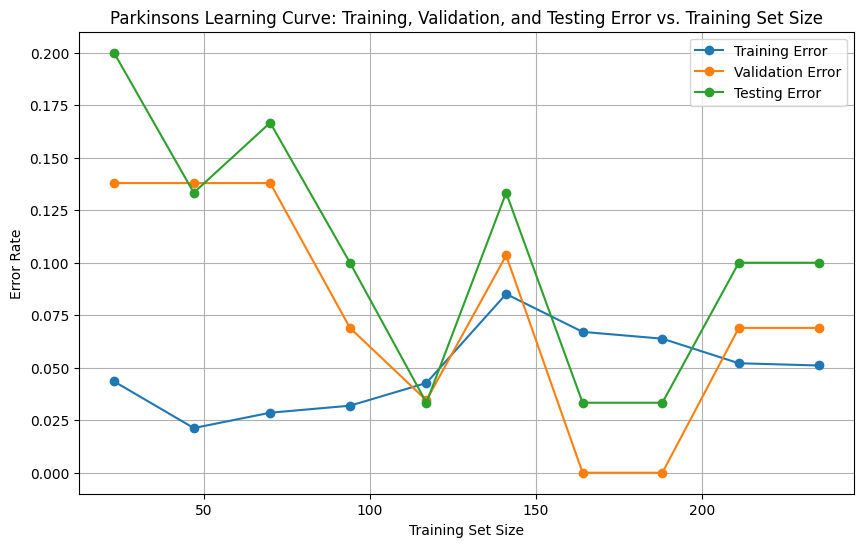

Training time for 23 samples: 0.016387 seconds
Training time for 47 samples: 0.005376 seconds
Training time for 70 samples: 0.008912 seconds
Training time for 94 samples: 0.001887 seconds
Training time for 117 samples: 0.002006 seconds
Training time for 141 samples: 0.002774 seconds
Training time for 164 samples: 0.002254 seconds
Training time for 188 samples: 0.002657 seconds
Training time for 211 samples: 0.013590 seconds
Training time for 235 samples: 0.015836 seconds


In [21]:
#hyperparameters
max_depth_value = 5
min_samples_split_value = 2
min_samples_leaf_value = 2
prune_value = 0.02

train_error_rates = []
valid_error_rates = []
test_error_rates = []
training_sizes = []
training_times = []

training_set_sizes = np.arange(0.1, 1.1, 0.1)

for training_size in training_set_sizes:
    num_samples = int(training_size * len(X_train))
    X_subset = X_train[:num_samples]
    y_subset = y_train[:num_samples]


    dt_model = DecisionTreeClassifier(random_state=14, max_depth=max_depth_value,
                                       min_samples_split=min_samples_split_value,
                                       min_samples_leaf=min_samples_leaf_value,
                                       ccp_alpha=prune_value)

    start_time = time.time()
    dt_model.fit(X_subset, y_subset)
    end_time = time.time()
    training_time = end_time - start_time


    train_error = 1 - dt_model.score(X_subset, y_subset)
    valid_error = 1 - dt_model.score(X_valid, y_valid)
    test_error = 1 - dt_model.score(X_test, y_test)

    train_error_rates.append(train_error)
    valid_error_rates.append(valid_error)
    test_error_rates.append(test_error)
    training_sizes.append(num_samples)
    training_times.append(training_time)


plt.figure(figsize=(10, 6))
plt.plot(training_sizes, train_error_rates, marker='o', label='Training Error')
plt.plot(training_sizes, valid_error_rates, marker='o', label='Validation Error')
plt.plot(training_sizes, test_error_rates, marker='o', label='Testing Error')
plt.title('Parkinsons Learning Curve: Training, Validation, and Testing Error vs. Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()


for size, time_ in zip(training_sizes, training_times):
    print(f"Training time for {size} samples: {time_:.6f} seconds")

In [68]:
dt_model= DecisionTreeClassifier(random_state=14, ccp_alpha=0.01, max_depth=3, min_samples_split=2, min_samples_leaf=2)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=3, min_samples_leaf=2,
                       random_state=14)

In [69]:
y_pred = dt_model.predict(X_test)

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        13
           1       1.00      0.82      0.90        17

    accuracy                           0.90        30
   macro avg       0.91      0.91      0.90        30
weighted avg       0.92      0.90      0.90        30



#kNN Implementation

In [44]:
from sklearn.neighbors import KNeighborsClassifier

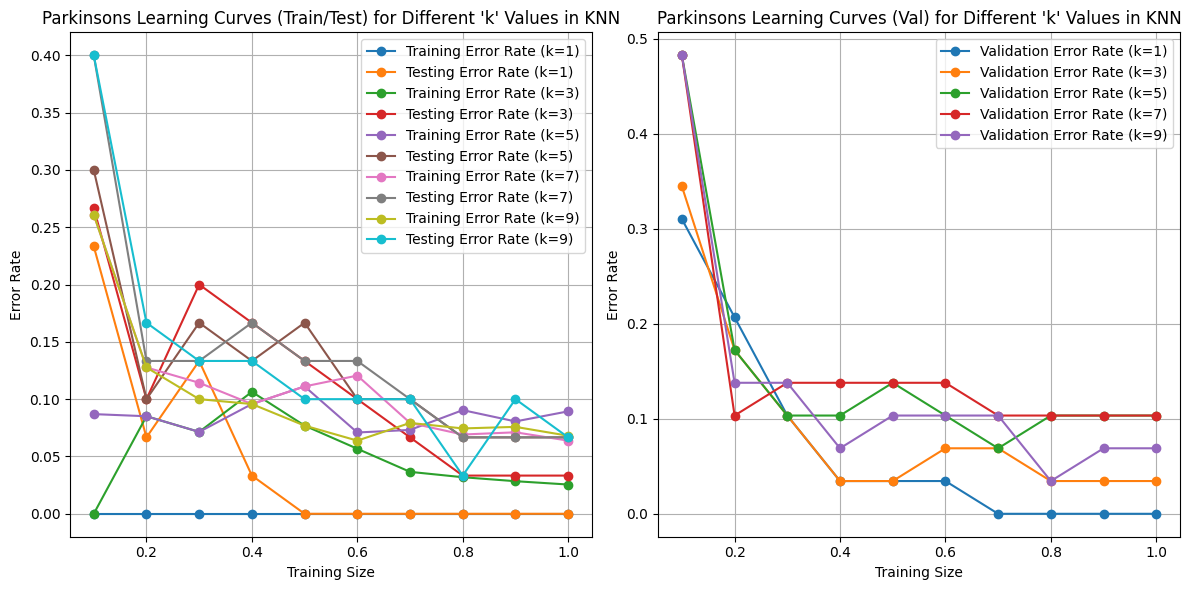

Training time for k=1, 10.0% of data: 0.011075 seconds
Training time for k=1, 20.0% of data: 0.001060 seconds
Training time for k=1, 30.0% of data: 0.004470 seconds
Training time for k=1, 40.0% of data: 0.001028 seconds
Training time for k=1, 50.0% of data: 0.006609 seconds
Training time for k=1, 60.0% of data: 0.001225 seconds
Training time for k=1, 70.0% of data: 0.001294 seconds
Training time for k=1, 80.0% of data: 0.001209 seconds
Training time for k=1, 90.0% of data: 0.001269 seconds
Training time for k=1, 100.0% of data: 0.001243 seconds
Training time for k=3, 10.0% of data: 0.000967 seconds
Training time for k=3, 20.0% of data: 0.000991 seconds
Training time for k=3, 30.0% of data: 0.008396 seconds
Training time for k=3, 40.0% of data: 0.001037 seconds
Training time for k=3, 50.0% of data: 0.001341 seconds
Training time for k=3, 60.0% of data: 0.001075 seconds
Training time for k=3, 70.0% of data: 0.001190 seconds
Training time for k=3, 80.0% of data: 0.001176 seconds
Training 

In [67]:
train_sizes = np.linspace(0.1, 1.0, 10)

k_values = [1, 3, 5, 7, 9]  # defining various levels of k to be tested

train_error_rates = {k: [] for k in k_values}
valid_error_rates = {k: [] for k in k_values}
test_error_rates = {k: [] for k in k_values}
training_times = {k: [] for k in k_values}

for train_size in train_sizes:
    num_samples = int(train_size * len(X_train))
    X_subset = X_train[:num_samples]
    y_subset = y_train[:num_samples]

    for k in k_values:
        knn_model = KNeighborsClassifier(n_neighbors=k)

        start_time = time.time()
        knn_model.fit(X_subset, y_subset)
        end_time = time.time()
        training_time = end_time - start_time

        train_accuracy = accuracy_score(y_subset, knn_model.predict(X_subset))
        valid_accuracy = accuracy_score(y_valid, knn_model.predict(X_valid))
        test_accuracy = accuracy_score(y_test, knn_model.predict(X_test))

        train_error = 1 - train_accuracy
        valid_error = 1 - valid_accuracy
        test_error = 1 - test_accuracy

        train_error_rates[k].append(train_error)
        valid_error_rates[k].append(valid_error)
        test_error_rates[k].append(test_error)
        training_times[k].append(training_time)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for k in k_values:
    plt.plot(train_sizes, train_error_rates[k], 'o-', label=f"Training Error Rate (k={k})")
    plt.plot(train_sizes, test_error_rates[k], 'o-', label=f"Testing Error Rate (k={k})")

plt.title("Parkinsons Learning Curves (Train/Test) for Different 'k' Values in KNN")
plt.xlabel("Training Size")
plt.ylabel("Error Rate")
plt.legend(loc="best")
plt.grid(True)

plt.subplot(1, 2, 2)
for k in k_values:
    plt.plot(train_sizes, valid_error_rates[k], 'o-', label=f"Validation Error Rate (k={k})")

plt.title("Parkinsons Learning Curves (Val) for Different 'k' Values in KNN")
plt.xlabel("Training Size")
plt.ylabel("Error Rate")
plt.legend(loc="best")
plt.grid(True)

plt.tight_layout()
plt.show()

# Print training times
for k in k_values:
    for size, time_ in zip(train_sizes, training_times[k]):
        print(f"Training time for k={k}, {size:.1%} of data: {time_:.6f} seconds")

In [26]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(X_train, y_train) #using the training data

KNeighborsClassifier(n_neighbors=1)

In [27]:
y_pred = knn_model.predict(X_test) #create predict based on test set

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        17

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



#SVM Implementation

In [29]:
from sklearn.svm import SVC

In [30]:
kernel_functions = ['linear', 'poly', 'rbf', 'sigmoid']

Kernel: linear
Kernel: poly
Kernel: rbf
Kernel: sigmoid


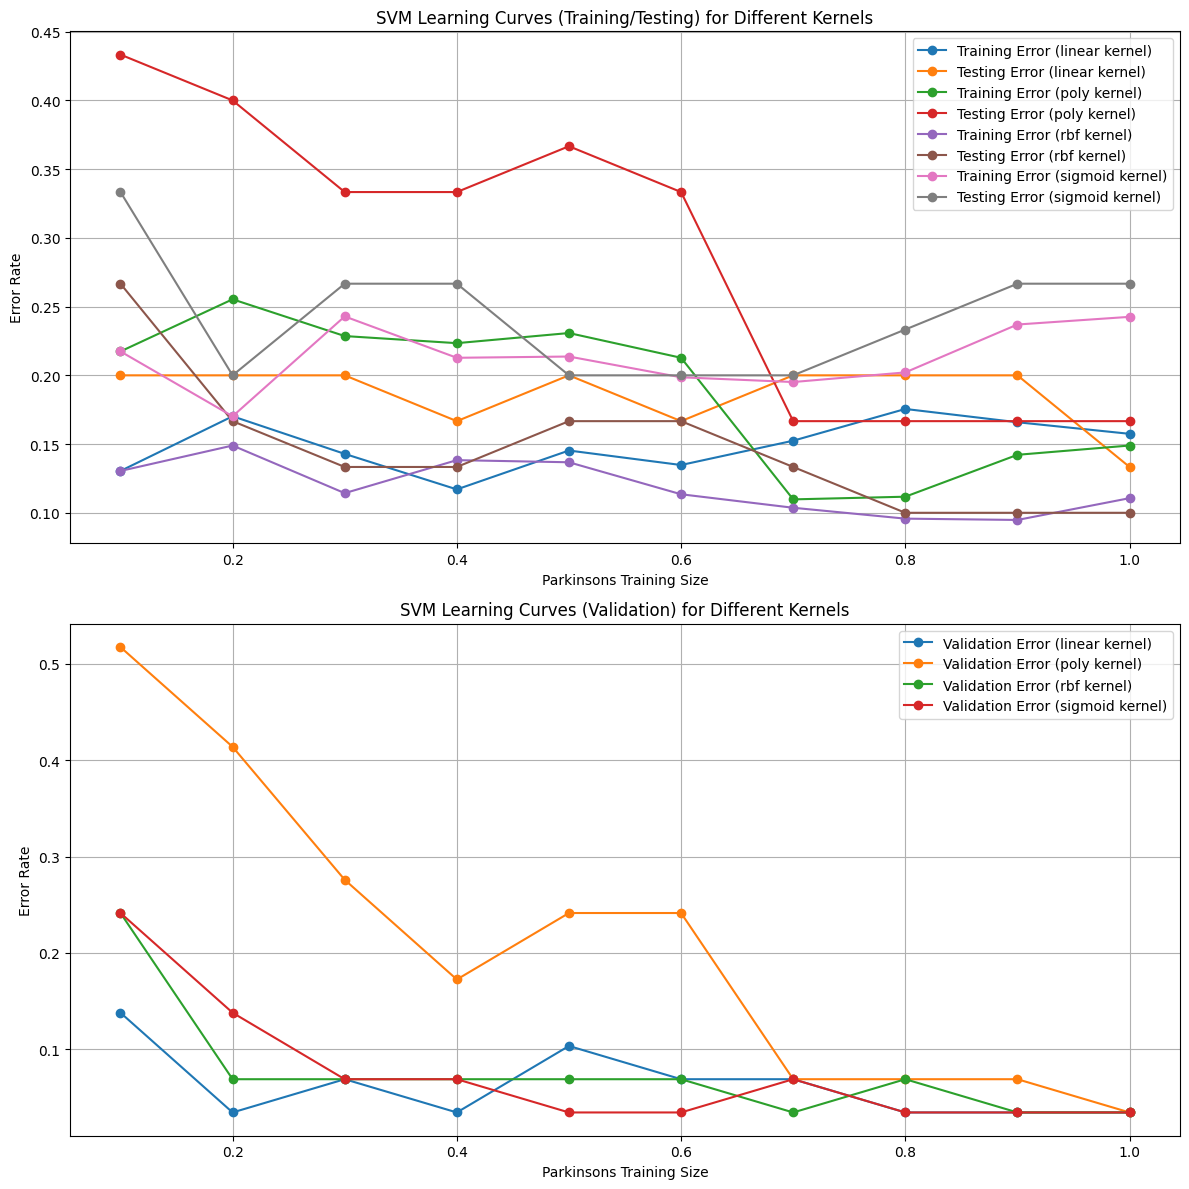

Training time for linear kernel, 10.0% of data: 0.002169 seconds
Training time for linear kernel, 20.0% of data: 0.001630 seconds
Training time for linear kernel, 30.0% of data: 0.002341 seconds
Training time for linear kernel, 40.0% of data: 0.002071 seconds
Training time for linear kernel, 50.0% of data: 0.002322 seconds
Training time for linear kernel, 60.0% of data: 0.002547 seconds
Training time for linear kernel, 70.0% of data: 0.002985 seconds
Training time for linear kernel, 80.0% of data: 0.004275 seconds
Training time for linear kernel, 90.0% of data: 0.003903 seconds
Training time for linear kernel, 100.0% of data: 0.004033 seconds
Training time for poly kernel, 10.0% of data: 0.001443 seconds
Training time for poly kernel, 20.0% of data: 0.001526 seconds
Training time for poly kernel, 30.0% of data: 0.001649 seconds
Training time for poly kernel, 40.0% of data: 0.001831 seconds
Training time for poly kernel, 50.0% of data: 0.002019 seconds
Training time for poly kernel, 60.

In [47]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_error_rates = {kernel: [] for kernel in kernel_functions}
valid_error_rates = {kernel: [] for kernel in kernel_functions}
test_error_rates = {kernel: [] for kernel in kernel_functions}
training_times = {kernel: [] for kernel in kernel_functions}

for kernel in kernel_functions:
    print(f"Kernel: {kernel}")

    for train_size in train_sizes:
        num_samples = int(train_size * len(X_train))
        X_subset = X_train[:num_samples]
        y_subset = y_train[:num_samples]

        svm_model = SVC(kernel=kernel)

        start_time = time.time()
        svm_model.fit(X_subset, y_subset)
        end_time = time.time()
        training_time = end_time - start_time

        train_accuracy = svm_model.score(X_subset, y_subset)
        valid_accuracy = svm_model.score(X_valid, y_valid)
        test_accuracy = svm_model.score(X_test, y_test)

        train_error = 1 - train_accuracy
        valid_error = 1 - valid_accuracy
        test_error = 1 - test_accuracy

        train_error_rates[kernel].append(train_error)
        valid_error_rates[kernel].append(valid_error)
        test_error_rates[kernel].append(test_error)
        training_times[kernel].append(training_time)

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
for kernel in kernel_functions:
    plt.plot(train_sizes, train_error_rates[kernel], marker='o', label=f"Training Error ({kernel} kernel)")
    plt.plot(train_sizes, test_error_rates[kernel], marker='o', label=f"Testing Error ({kernel} kernel)")

plt.title("SVM Learning Curves (Training/Testing) for Different Kernels")
plt.xlabel("Parkinsons Training Size")
plt.ylabel("Error Rate")
plt.legend(loc="best")
plt.grid(True)

plt.subplot(2, 1, 2)
for kernel in kernel_functions:
    plt.plot(train_sizes, valid_error_rates[kernel], marker='o', label=f"Validation Error ({kernel} kernel)")

plt.title("SVM Learning Curves (Validation) for Different Kernels")
plt.xlabel("Parkinsons Training Size")
plt.ylabel("Error Rate")
plt.legend(loc="best")
plt.grid(True)

plt.tight_layout()
plt.show()

for kernel in kernel_functions:
    for size, time_ in zip(train_sizes, training_times[kernel]):
        print(f"Training time for {kernel} kernel, {size:.1%} of data: {time_:.6f} seconds")

Kernel: linear
Kernel: poly
Kernel: rbf
Kernel: sigmoid


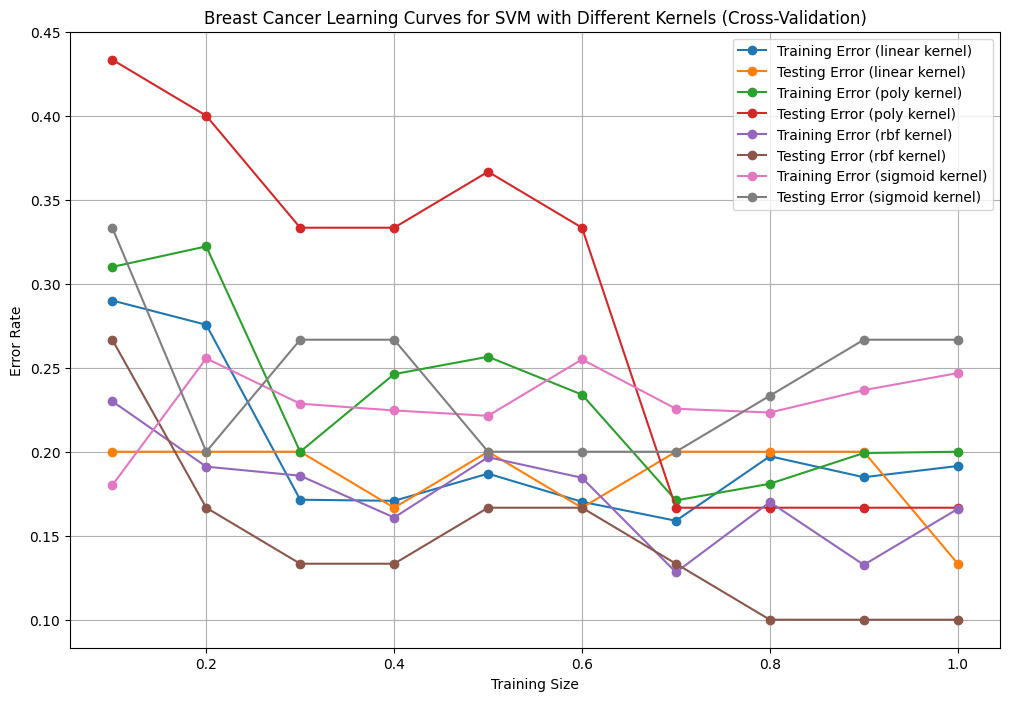

In [83]:
### THIS SECTION IS THE SAME ABOVE BUT IMPLEMENTS CROSS VALIDATION ###
from sklearn.model_selection import cross_val_score

train_sizes = np.linspace(0.1, 1.0, 10)
train_error_rates = {kernel: [] for kernel in kernel_functions}
test_error_rates = {kernel: [] for kernel in kernel_functions}

for kernel in kernel_functions:
    print(f"Kernel: {kernel}")

    for train_size in train_sizes:

        num_samples = int(train_size * len(X_train))
        X_subset = X_train[:num_samples]
        y_subset = y_train[:num_samples]
        svm_model = SVC(kernel=kernel)

        scores = cross_val_score(svm_model, X_subset, y_subset, cv=5)  # CV changes the number of folds, here I have it to 5 but 10 is also a common number. My dataset is too small for 10 IMO.
        train_error = 1 - np.mean(scores)
        test_error = 1 - svm_model.fit(X_subset, y_subset).score(X_test, y_test)

        train_error_rates[kernel].append(train_error)
        test_error_rates[kernel].append(test_error)

plt.figure(figsize=(12, 8))

for kernel in kernel_functions:
    plt.plot(train_sizes, train_error_rates[kernel], marker='o', label=f"Training Error ({kernel} kernel)")
    plt.plot(train_sizes, test_error_rates[kernel], marker='o', label=f"Testing Error ({kernel} kernel)")

plt.title("Breast Cancer Learning Curves for SVM with Different Kernels (Cross-Validation)")
plt.xlabel("Training Size")
plt.ylabel("Error Rate")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [74]:
for kernel in kernel_functions:
    print(f"Kernel: {kernel}")

    svm_model = SVC(kernel=kernel, degree=1) #creatin a SVM model with the specified kernel function

    svm_model.fit(X_train, y_train)     # Fitting the model on the training data

    y_pred = svm_model.predict(X_test) #Making predictions on the test data

    # classification report
    print(classification_report(y_test, y_pred))
    print("=" * 40)

Kernel: linear
              precision    recall  f1-score   support

           0       0.76      1.00      0.87        13
           1       1.00      0.76      0.87        17

    accuracy                           0.87        30
   macro avg       0.88      0.88      0.87        30
weighted avg       0.90      0.87      0.87        30

Kernel: poly
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        13
           1       1.00      0.71      0.83        17

    accuracy                           0.83        30
   macro avg       0.86      0.85      0.83        30
weighted avg       0.88      0.83      0.83        30

Kernel: rbf
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        13
           1       1.00      0.82      0.90        17

    accuracy                           0.90        30
   macro avg       0.91      0.91      0.90        30
weighted avg       0.92      0.90 

#Neural Net Implementation

In [35]:
import tensorflow as tf

In [36]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.title('Parkinsons Loss Curve')
  plt.xlabel('Epoch')
  plt.ylabel('Binary Crossentropy')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='Accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.title('Parkinsons Accuracy Curve')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()


In [81]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(8, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])



In [82]:
history = nn_model.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 16,
    validation_split = 0.2,
    verbose = False
)

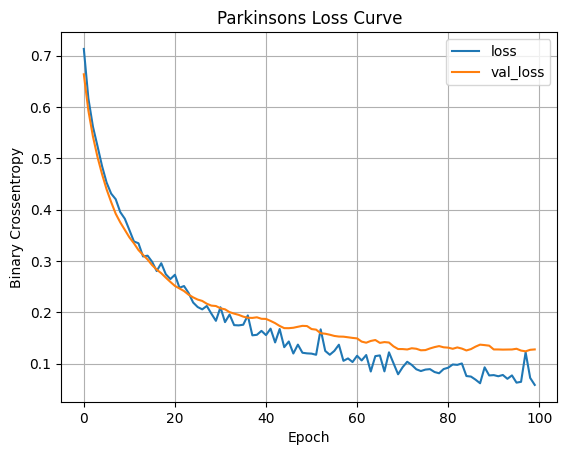

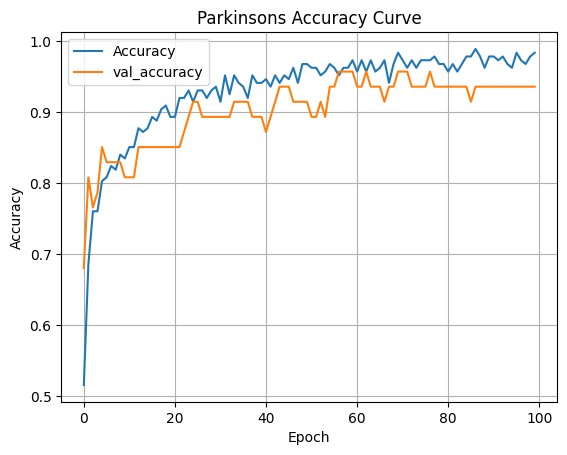

In [80]:
plot_loss(history)
plot_accuracy(history)

#Boosting Implementation

In [40]:
from xgboost import XGBClassifier

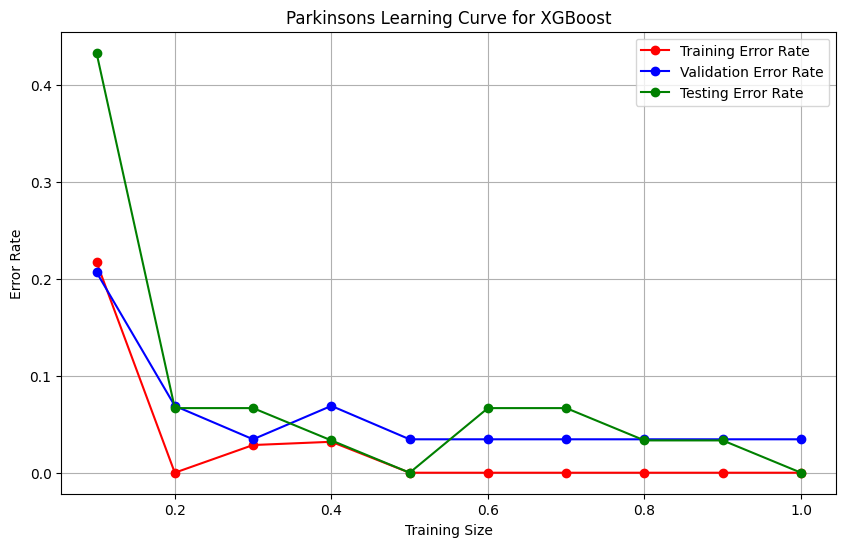

Training time for 10.0% of data: 0.091032 seconds
Training time for 20.0% of data: 0.884152 seconds
Training time for 30.0% of data: 0.643769 seconds
Training time for 40.0% of data: 0.470722 seconds
Training time for 50.0% of data: 0.395574 seconds
Training time for 60.0% of data: 0.768916 seconds
Training time for 70.0% of data: 0.115238 seconds
Training time for 80.0% of data: 0.236392 seconds
Training time for 90.0% of data: 0.204309 seconds
Training time for 100.0% of data: 0.282892 seconds


In [42]:
#hyperparameters
max_depth_value = 2
min_child_weight_value = 2

train_sizes = np.linspace(0.1, 1.0, 10)

train_error_rates = []
valid_error_rates = []
test_error_rates = []
training_times = []

for train_size in train_sizes:
    num_samples = int(train_size * len(X_train))
    X_subset = X_train[:num_samples]
    y_subset = y_train[:num_samples]

    xgb_model = XGBClassifier(
        max_depth=max_depth_value,
        min_child_weight=min_child_weight_value,
        random_state=42
    )

    start_time = time.time()
    xgb_model.fit(X_subset, y_subset)
    end_time = time.time()
    training_time = end_time - start_time

    train_accuracy = accuracy_score(y_subset, xgb_model.predict(X_subset))
    valid_accuracy = accuracy_score(y_valid, xgb_model.predict(X_valid))
    test_accuracy = accuracy_score(y_test, xgb_model.predict(X_test))

    train_error = 1 - train_accuracy
    valid_error = 1 - valid_accuracy
    test_error = 1 - test_accuracy

    train_error_rates.append(train_error)
    valid_error_rates.append(valid_error)
    test_error_rates.append(test_error)
    training_times.append(training_time)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_error_rates, 'o-', color="r", label="Training Error Rate")
plt.plot(train_sizes, valid_error_rates, 'o-', color="b", label="Validation Error Rate")
plt.plot(train_sizes, test_error_rates, 'o-', color="g", label="Testing Error Rate")
plt.title("Parkinsons Learning Curve for XGBoost")
plt.xlabel("Training Size")
plt.ylabel("Error Rate")
plt.legend(loc="best")
plt.grid(True)
plt.show()

for size, time_ in zip(train_sizes, training_times):
    print(f"Training time for {size:.1%} of data: {time_:.6f} seconds")

In [ ]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
y_pred = xgb_model.predict(X_test) #create predict based on test set

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        24
           1       0.97      0.97      0.97        35

    accuracy                           0.97        59
   macro avg       0.96      0.96      0.96        59
weighted avg       0.97      0.97      0.97        59

